# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
!git clone https://github.com/lrpalmer27/Mask-RCNN-TF2 /content/drive/MyDrive/mask_rcnn

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import random as rd
import json
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append("/content/drive/MyDrive/mask_rcnn/")  # To find local version of the library
# from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

2024-05-23 16:49:12.288201: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 16:49:12.309526: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 16:49:12.621324: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
sys.path.append(os.path.join(sys.path[0], 'mrcnn'))

## Configurations

In [15]:
from mrcnn.config import Config


class ImgsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "placneta"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 1 shape

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5

config = ImgsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [5]:
train_path = "data_demo/image2label_train.json"
train_backup_path = "data_demo/image2label_train_bck.json"
test_path = "data_demo/label2image_test.json"
test_backup_path = "data_demo/image2label_test_bck.json"
# restore test and train json
test_json = open(test_backup_path)
test_dict = json.load(test_json)
train_json = open(train_backup_path)
train_dict = json.load(train_json)
#restore type dict specifically
accreta_dict = {}
increta_dict = {}
normal_dict = {}
type_dict = {}
rc_test_dict = {}
all_dict = {}
for img in train_dict:
  type_dict[img] = img.split(os.path.sep)[2]
for label in test_dict:
  img = test_dict[label]
  type_dict[img] = img.split(os.path.sep)[2]
  if (type_dict[img] == "accreta"):
    accreta_dict[label] = img
  elif (type_dict[img] == "increta"):
    increta_dict[label] = img
  elif (type_dict[img] == "normal"):
    normal_dict[label] = img
#spetial to reverse
for k, v in test_dict.items():
  rc_test_dict[v] = []
  rc_test_dict[v].append(k)
all_dict = {**train_dict, **rc_test_dict}

In [6]:
from itertools import islice
import cv2
def nth_key(dct, n):
    it = iter(dct)
    # Consume n elements.
    next(islice(it, n, n), None)
    # Return the value at the current position.
    # This raises StopIteration if n is beyond the limits.
    # Use next(it, None) to suppress that exception.
    return next(it)

In [26]:
nth_key(train_dict, 328)

'data_demo/images/increta/凌菊2/1.2.840.113663.1500.1.420177491.3.24.20220623.143632.862.jpg'

In [7]:
np.bool = np.bool_
class ImgsDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_images(self, source, x_dict, *ts):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        source = "placenta"
        # Add classes
        for i in range(len(ts)):
          self.add_class(source, i+1, ts[i])

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(len(x_dict)):
            img = nth_key(x_dict, i)
            self.add_image(source=source, image_id=i, path=img,
                          placenta_type = type_dict[img])

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "placenta":
            return info["placenta_type"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, img):
        """Generate instance masks for shapes of the given image ID.
        """
        mask = cv2.imread(all_dict[img][0])
        class_ids = np.array([self.class_names.index(type_dict[img])])
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [8]:
# Training dataset
dataset_train = ImgsDataset()
dataset_train.load_images("placenta", train_dict, "normal", "accreta", "increta")
dataset_train.prepare()

# Validation dataset
dataset_val = ImgsDataset()
dataset_val.load_images("placenta", rc_test_dict, "normal", "accreta", "increta")
dataset_val.prepare()

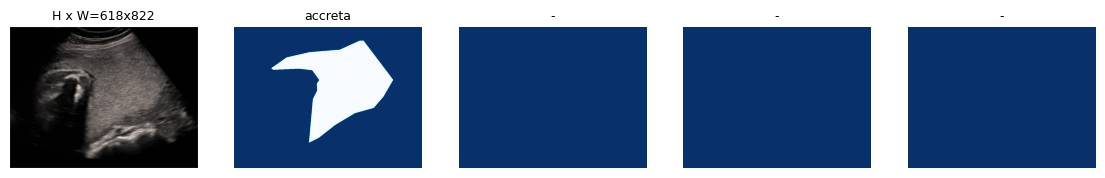

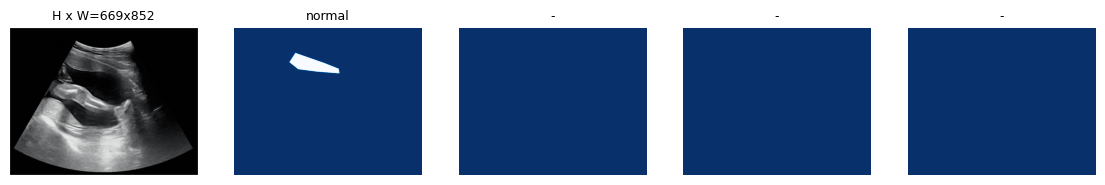

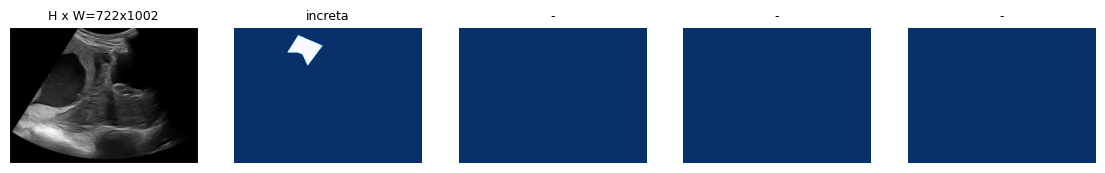

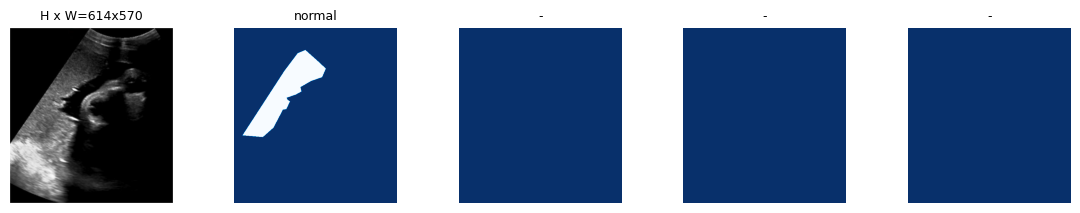

In [9]:
# Load and display random samples
imgs = np.random.choice(list(train_dict.keys()), 4)
for img in imgs:
    mask, class_ids = dataset_train.load_mask(img)
    img = cv2.imread(img)
    visualize.display_top_masks(img, mask, class_ids, dataset_train.class_names)

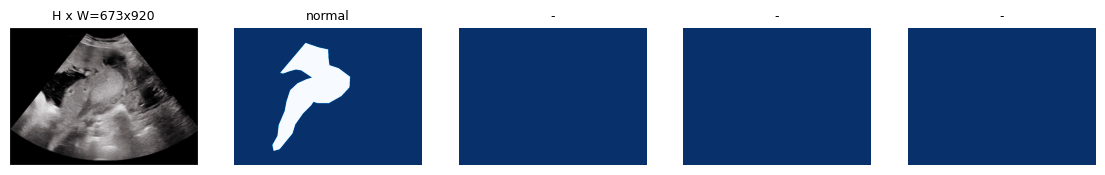

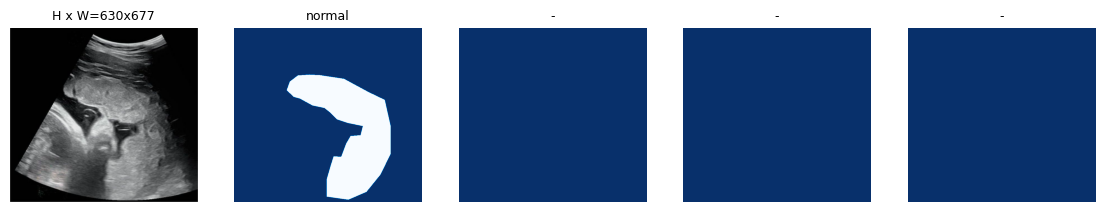

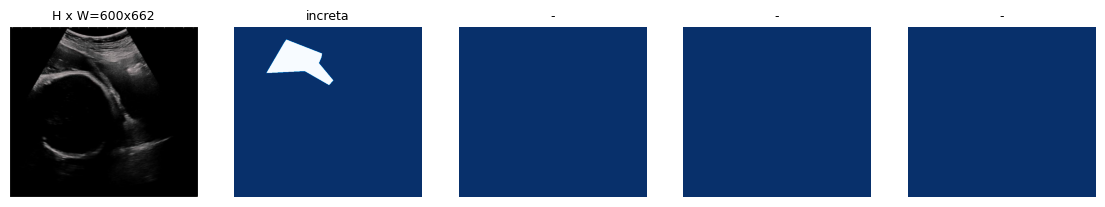

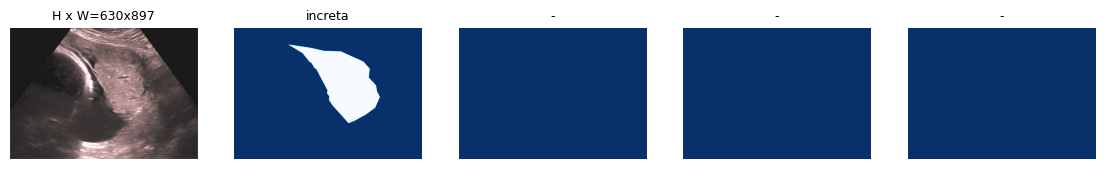

In [10]:
# Load and display random samples
imgs = np.random.choice(list(rc_test_dict.keys()), 4)
for img in imgs:
    mask, class_ids = dataset_val.load_mask(img)
    img = cv2.imread(img)
    visualize.display_top_masks(img, mask, class_ids, dataset_val.class_names)

## Create Model

In [ ]:
!git remote set-url origin https://gitclone.com/github.com/leekunhee/Mask_RCNN.git
!git pull origin master:main

In [ ]:
!git reset --hard origin/master
!git pull origin master:master

In [16]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [17]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

2024-05-23 16:55:38.361293: W tensorflow/c/c_api.cc:304] Operation '{name:'bn4o_branch2a/beta/Assign' id:3509 op device:{requested: '', assigned: ''} def:{{{node bn4o_branch2a/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bn4o_branch2a/beta, bn4o_branch2a/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [23]:
print("Train items: ", len(train_dict), "; Val items: ", len(rc_test_dict), "; all itmes: ", len(all_dict))

Train items:  509 ; Val items:  126 ; all itmes:  635


In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=10,
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/lmj/xyx/Mask_RCNN/logs/placneta20240523T1655/mask_rcnn_placneta_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deco

2024-05-23 17:36:48.925988: W tensorflow/c/c_api.cc:304] Operation '{name:'range_35' id:32804 op device:{requested: '', assigned: ''} def:{{{node range_35}} = Range[Tidx=DT_INT32, _has_manual_control_dependencies=true](range_35/start, Rank_35, range_35/delta)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-23 17:36:49.649942: W tensorflow/c/c_api.cc:304] Operation '{name:'range_36' id:32814 op device:{requested: '', assigned: ''} def:{{{node range_36}} = Range[Tidx=DT_INT32, _has_manual_control_dependencies=true](range_36/start, Rank_36, range_36/delta)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-23 17:36:50.385808: W tensorflow/c/c_api.cc:30

Epoch 1/10


In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2,
            layers="all")

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config,
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)

print("mAP: ", np.mean(APs))